In [22]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import scipy.stats as sc
from scipy.stats import norm
import yfinance as yf
from tqdm import tqdm
plt.style.use('default')
%matplotlib notebook

In [23]:
def gbm(S0: float, r: float, sigma: float, T: float, time_steps: int, n_paths: int, 
        random_generator = sc.norm(0, 1)):
    """
    Generate Geometric Brownian Motion paths
    :param S0: float, starting price
    :param r: float, risk free rate
    :param sigma: float, volatility
    :param T: float, time horizon
    :param time_steps: int, how many subintervals include from 0 to T
    :param n_paths: int, how many paths to simulate
    :param random_generator: distribution family from which to draw random increments
    :return: paths: ndarray, simulated paths
    """
    
    dt = float(T) / time_steps
    paths = np.zeros((time_steps + 1, n_paths), np.float64)
    paths[0] = S0
    for t in range(1, time_steps + 1):
        rand = random_generator.rvs(size = n_paths)
        paths[t] = paths[t - 1] * np.exp((r - 0.5 * sigma ** 2) * dt +
                                         sigma * np.sqrt(dt) * rand)
    return paths


In [24]:
def d_plus(S, K, r, sig, T):
    return (np.log(S/K) + (r + sig**2/2)*T)/(sig*np.sqrt(T))

def d_minus(S, K, r, sig, T):
    return d_plus(S, K, r, sig, T) - sig*np.sqrt(T)

def vanilla_price(S0:float, K:float, option_type:str, r:float, sig:float, T:float):
    
    d1 = d_plus(S0, K, r, sig, T)
    d2 = d_minus(S0, K, r, sig, T)
        
    if option_type.upper() == "CALL":
        price = S0*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)
    else:
        price = K*np.exp(-r*T)*norm.cdf(-d2) - S0*norm.cdf(-d1)
    
    return price
    
    
def vanilla_delta(St: np.array, K:float, option_type: str, r: float, sig:float, T:float):
        
    if option_type.upper() == "CALL":
        delta = np.exp(-r*T)*norm.cdf(d_plus(St, K, r, sig, T))
    else:
        delta = np.exp(-r*T)*(norm.cdf(d_plus(St, K, r, sig, T))-1)
    
    return delta

def vanilla_gamma(St: np.array, K:float, option_type: str, r:float, sig:float, T:float):
    d1 = d_plus(S0, K, r, sig, T)
    gamma = norm.pdf(d1)/(St*sig*np.sqrt(T))
    return gamma

In [25]:
def run_animation(t: np.array, stochastic_process: np.ndarray, title: str, tempo:float = 1):

    X = stochastic_process.T
    N = X.shape[1] - 1
    m = X.shape[0]
    
    fig = plt.figure()
    ax = plt.axes(xlim=(t.min(), t.max()), ylim=(X.min() - 0.5, X.max() + 0.5))
    
    # lists to store x and y axis points 
    xdata = []
    ydata = []
    lines = []
    for l in range(m):
        line, = ax.plot([], [], lw=2)#, color='#0492C2')
        lines.append(line)
        ydata.append([])
        
    ax.set_ylabel('y')
    ax.set_xlabel('t')
    ax.set_title(title)
    ax.grid(True, which='major', linestyle='--', color='black', alpha=0.4)
    
    # initialization function 
    def init(): 
        # creating an empty plot/frame 
        for line in lines:
            line.set_data([], []) 
        return lines
    
    # animation function 
    def animate(i):
        # appending new points to x, y axes points list 
        xdata.append(t[i]) 
        for ind, line in enumerate(lines):
            ydata[ind].append(X[ind][i]) 
            line.set_data(xdata, ydata[ind]) 
        return lines,

    return animation.FuncAnimation(fig, animate, init_func=init, frames=N, interval=tempo*1000/N, repeat = False, blit=True)

<IPython.core.display.Javascript object>


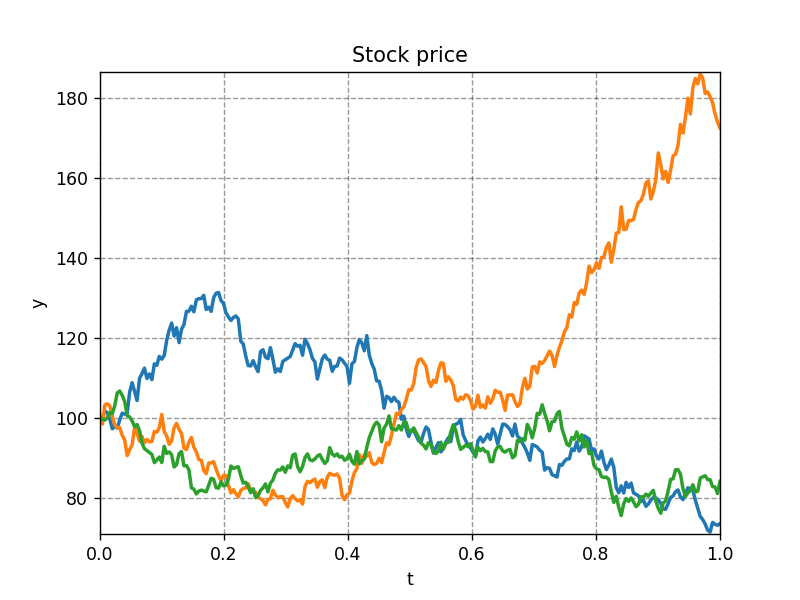

In [29]:
%matplotlib notebook
N = 252
n = 1
St = gbm(S0 = 100, r = 0.01, sigma = 0.3, T = 1, time_steps=N, n_paths = 3)
t = np.linspace(0, 1, N)
run_animation(t, St, 'Stock price')

## $\Delta$ hedging

Rozważymy cenę akcji $S_t$, instrumentu pochodnego $V_t$ oraz portfel $\Pi_t := V_t - \Delta \cdot S_t$.
Zauważmy, że $V_t$ to tak naprawdę $V(S_t, t; \sigma, \mu; K, T; r)$. 
Zakładając dynamikę GBM: $dS_t = \mu S_tdt + \sigma S_t dW_t$, ze wzoru Ito mamy:

$$dV_t = \frac{\partial V}{\partial t}dt + \frac{\partial V}{\partial S}dS + \frac{1}{2}\sigma^2S^2\frac{\partial^2V}{\partial S^2}dt$$

Na zmiany wartości portfela wpływają dwa składniki:

$$ d\Pi_t = dV_t - \Delta dS_t$$.
$$ d\Pi = \frac{\partial V}{\partial t}dt + \frac{\partial V}{\partial S}dS + \frac{1}{2}\sigma^2S^2\frac{\partial^2V}{\partial S^2}dt - \Delta dS$$
$$ d\Pi = \Big(\frac{\partial V}{\partial t} +  \frac{1}{2}\sigma^2S^2\frac{\partial^2V}{\partial S^2} \Big)dt + \Big(\frac{\partial V}{\partial S} - \Delta \Big)dS $$

Widzimy dwa źródła dynamiki: deterministyczne, oraz losowe. Dobierając jednak $\Delta = \frac{\partial V}{\partial S}$, część losowa znika z równania, a nasz portfel staje się instrumentem bez ryzyka.

$$ d\Pi = \Big(\frac{\partial V}{\partial t} +  \frac{1}{2}\sigma^2S^2\frac{\partial^2V}{\partial S^2} \Big)dt $$ 

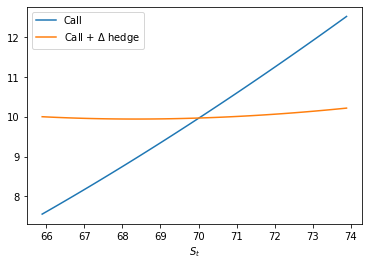

In [31]:
%matplotlib inline

MC = 10000
dt = 1/365

r = 0.05
sig = 0.3
T = 1
S0 = 70
option_type = 'CALL'
K = 70

delta = vanilla_delta(S0, K, option_type, r, sig, T)
V_0 = vanilla_price(S0, K, option_type, r, sig, T)

S_1D = gbm(S0, r, sig, dt, 1, MC)[-1]
# _ = plt.hist(S_1D, bins = 100)

S_1D = np.linspace(S_1D.min(), S_1D.max(), 100)
V_1D = vanilla_price(S_1D, K, option_type, r, sig, T)

DH_1D = V_1D - (delta*S_1D - (delta*S0)*np.exp(r*dt))
plt.plot(S_1D, V_1D, label = 'Call')
plt.plot(S_1D, DH_1D, label = 'Call + $\Delta$ hedge')
plt.xlabel('$S_t$')

#_ = plt.hist(V_1D, bins = 100)
#_ = plt.hist(DH_1D, bins = 100)
_ = plt.legend()

## $\Delta$ - $\gamma$ hedging

Przy pomocy $Delta$-hedgingu pozbyliśmy się liniowego wpływu $S_t$ na cenę opcji. To jednak nie wszystko co można zrobić - można również zabezpieczać się przed nieliniowym wpływem, poprzez dobranie $\gamma = 0$ dla portfela.

Gammą $\gamma$ instrumentu $V_t$ nazywamy $\frac{\partial^2 V}{\partial S^2}$. Jeżeli ta wartość wyniesie zero, to portfel nazwiemy delta-gamma-neutralnym.

$$ d\Pi = \Big(\frac{\partial V}{\partial t} +  \frac{1}{2}\sigma^2S^2\frac{\partial^2V}{\partial S^2} \Big)dt $$ 

$$ d\Pi = \Big(\frac{\partial V}{\partial t} + 0 \Big)dt $$ 

Oryginalnie, by wyzerować deltę należało posłużyć się innym, dodatkowym instrumentem finansowym. Podobnie teraz, aby wyzerować i deltę i gammę na raz, musimy dołożyć dwa instrumenty. Zajmiemy więc pozycję $x$ w akcji $S$, pozycję $y$ w opcji $C$, oraz sfinalizujemy to pozycją $z$ w obligacjach taką, żeby cały hedge był bezkosztowy. 

Przed tym jednak dobierzemy $(x, y)$ w sposób, który wyzeruje deltę i gammę pozycji. Aby je znaleźć rozwiązujemy układ równań:

$$ 0 = \Delta_V = x \cdot \Delta_S + y \cdot \Delta_C $$

$$ 0 = \gamma_V = x \cdot \gamma_S + y \cdot \gamma_C$$


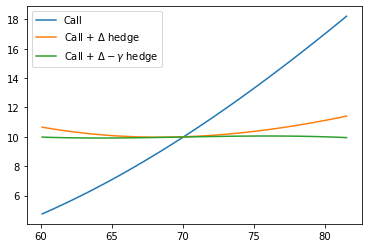

In [32]:
%matplotlib inline

MC = 10000

r = 0.05
sig = 0.3
T = 1.0
S0 = 70
option_type = 'CALL'
K = 70
k = K + 30
dt = 7/365

delta_V0 = vanilla_delta(S0, K, option_type, r, sig, T)
gamma_V0 = vanilla_gamma(S0, K, option_type, r, sig, T)
V0 = vanilla_price(S0, K, option_type, r, sig, T)

delta_S0 = 1
gamma_S0 = 0
S0 = S0

delta_C0 = vanilla_delta(S0, k, option_type, r, sig, T)
gamma_C0 = vanilla_gamma(S0, k, option_type, r, sig, T)
C0 = vanilla_price(S0, k, option_type, r, sig, T)

# AX = B
A = np.array([[delta_S0, delta_C0], [gamma_S0, gamma_C0]])
B = np.array([[-delta_V0], [-gamma_V0]])

x, y = np.linalg.solve(A, B)


S_1D = gbm(S0, r, sig, dt, 1, MC)[-1]
S_1D = np.linspace(S_1D.min(), S_1D.max(), 100)
V_1D = vanilla_price(S_1D, K, option_type, r, sig, T)
C_1D = vanilla_price(S_1D, k, option_type, r, sig, T)

DH_1D = V_1D - (delta*S_1D - (delta*S0)*np.exp(r*dt))
DGH_1D = V_1D + x*S_1D + y*C_1D - (x*S0 + y*C0)*np.exp(r*dt)
plt.plot(S_1D, V_1D, label = 'Call')
plt.plot(S_1D, DH_1D, label = 'Call + $\Delta$ hedge')
plt.plot(S_1D, DGH_1D, label = 'Call + $\Delta-\gamma$ hedge')

#_ = plt.hist(V_1D, bins = 100)
#_ = plt.hist(DH_1D, bins = 100)
_ = plt.legend()

## Dynamic hedging

In [33]:
def dynamic_hedging(stock_trajectory, option_to_hedge, option_for_gamma):
    
    gbm_traj = stock_trajectory
    option_type, K = option_to_hedge
    option_type2, K2 = option_for_gamma
    
    t_axis = np.linspace(0, T, len(gbm_traj))
    dt = t_axis[1] - t_axis[0]


    Vt = []
    St = []
    Ct = []
    t=[]

    Strategies = {'DeltaHedge': {"t": [],
                                 "Value": [],
                                 "Stock": [],
                                 "MM": []},
                  'DeltaGammaHedge': {"t": [],
                                      "Value": [],
                                      "Stock": [],
                                      "Option": [],
                                      "MM":[]}
                 }
    for S, t_ in zip(gbm_traj[:-1], t_axis[:-1]):

        V = vanilla_price(S, K, option_type, r, sig, T-t_)
        C = vanilla_price(S, K2, option_type2, r, sig, T-t_)
        S = S

        if t_ == 0:
            DH = 0.0
            DGH = 0.0
        else:
            DH = Strategies['DeltaHedge']['Stock'][-1]*S + Strategies['DeltaHedge']['MM'][-1]*np.exp(r*dt)
            DGH = Strategies['DeltaGammaHedge']['Stock'][-1]*S + Strategies['DeltaGammaHedge']['Option'][-1]*C + Strategies['DeltaGammaHedge']['MM'][-1]*np.exp(r*dt)

        Strategies['DeltaHedge']['Value'].append(DH)
        Strategies['DeltaGammaHedge']['Value'].append(DGH)

        Vt.append(V)
        St.append(S)
        Ct.append(C)
        t.append(t_)

        # Greeks
        delta_V = vanilla_delta(S, K, option_type, r, sig, T-t_)
        delta_C = vanilla_delta(S, K2, option_type2, r, sig, T-t_)
        delta_S = 1.0

        gamma_V = vanilla_gamma(S, K, option_type, r, sig, T-t_)
        gamma_C = vanilla_gamma(S, K2, option_type2, r, sig, T-t_)
        gamma_S = 0.0

        # Delta hedging
        A = np.array([[delta_S, 0], [S, 1]])
        B = np.array([[delta_V], [DH]])
        X = np.linalg.solve(A, B)

        Strategies['DeltaHedge']['Stock'].append(X[0][0])
        Strategies['DeltaHedge']['MM'].append(X[1][0])

        #Delta-gamma hedging
        A = np.array([[delta_S, delta_C, 0], [gamma_S, gamma_C, 0], [S, C, 1]])
        B = np.array([[delta_V], [gamma_V], [DGH]])
        X = np.linalg.solve(A, B)

        Strategies['DeltaGammaHedge']['Stock'].append(X[0][0])
        Strategies['DeltaGammaHedge']['Option'].append(X[1][0])
        Strategies['DeltaGammaHedge']['MM'].append(X[2][0])


    t = np.array(t).reshape(-1, 1)
    Vt = np.array(Vt).reshape(-1, 1)
    Strategies['DeltaHedge']['Value'] = np.array(Strategies['DeltaHedge']['Value']).reshape(-1, 1)
    Strategies['DeltaGammaHedge']['Value'] = np.array(Strategies['DeltaGammaHedge']['Value']).reshape(-1, 1)
    
    return t, Vt, Strategies 


gbm_traj = gbm(S0 = 60, r = 0.05, sigma = 0.3, T = 1.0, time_steps = 252, n_paths = 1).ravel()

t, Vt, Strategies = dynamic_hedging(gbm_traj, option_to_hedge = ('CALL', 80), option_for_gamma = ('CALL', 70))

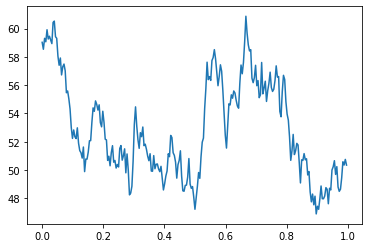

In [34]:
%matplotlib inline 
plt.plot(t, gbm_traj[1:])

<IPython.core.display.Javascript object>


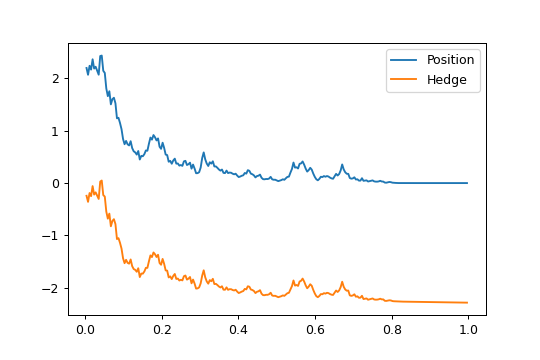

<IPython.core.display.Javascript object>


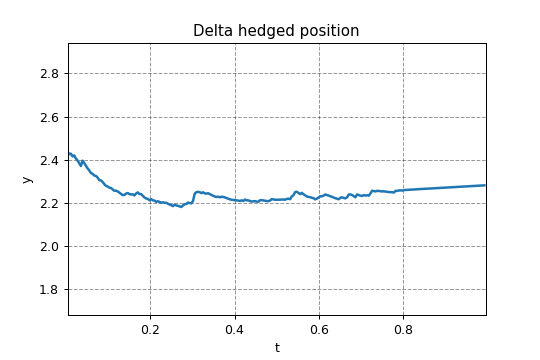

In [35]:
%matplotlib notebook
plt.plot(t[1:], Vt[1:], label = 'Position')
plt.plot(t[1:], Strategies['DeltaHedge']['Value'][1:], label = "Hedge")
plt.legend()

run_animation(t[1:], Vt[1:] - Strategies['DeltaHedge']['Value'][1:], "Delta hedged position")

<IPython.core.display.Javascript object>


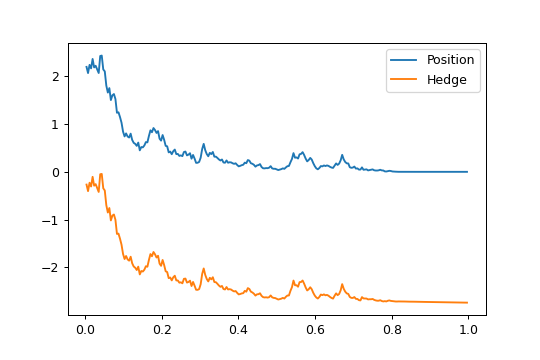

<IPython.core.display.Javascript object>


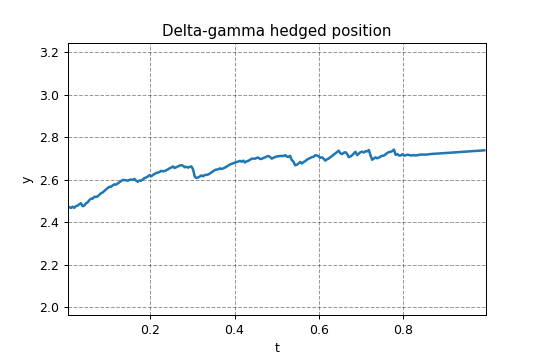

In [36]:
%matplotlib notebook
plt.plot(t[1:], Vt[1:], label = 'Position')
plt.plot(t[1:], Strategies['DeltaGammaHedge']['Value'][1:], label = "Hedge")
plt.legend()

run_animation(t[1:], Vt[1:] - Strategies['DeltaGammaHedge']['Value'][1:], "Delta-gamma hedged position")

# Przykład na danych rynkowych

In [41]:
ticker = "MSFT"
real_data = yf.download(ticker, start="2019-10-01", end="2020-10-30")['Open']

[*********************100%***********************]  1 of 1 completed


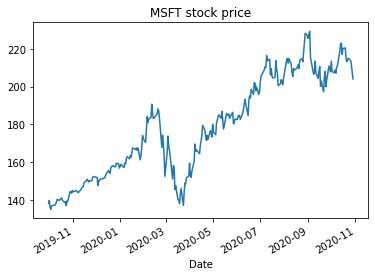

In [42]:
%matplotlib inline
real_data.plot()
_ = plt.title(f"{ticker} stock price")

In [43]:
t_real, Vt_real, Strategies_real = dynamic_hedging(real_data, option_to_hedge = ('CALL', 100), option_for_gamma = ('CALL', 80))

<IPython.core.display.Javascript object>


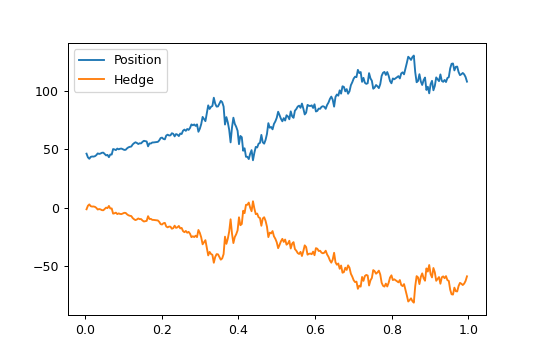

<IPython.core.display.Javascript object>


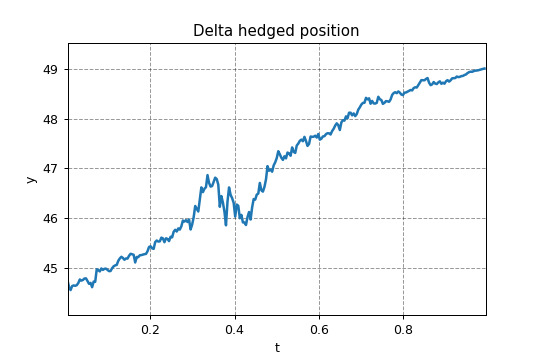

In [44]:
%matplotlib notebook
plt.plot(t_real[1:], Vt_real[1:], label = 'Position')
plt.plot(t_real[1:], -Strategies_real['DeltaHedge']['Value'][1:], label = "Hedge")
plt.legend()

run_animation(t_real[1:], Vt_real[1:] - Strategies_real['DeltaHedge']['Value'][1:], "Delta hedged position")

<IPython.core.display.Javascript object>


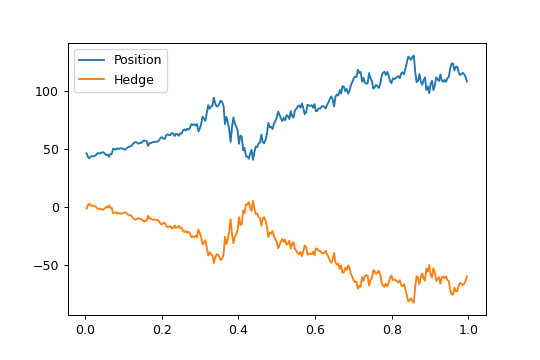

<IPython.core.display.Javascript object>


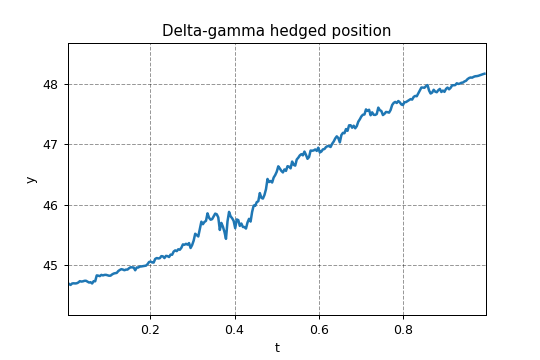

In [45]:
%matplotlib notebook
plt.plot(t_real[1:], Vt_real[1:], label = 'Position')
plt.plot(t_real[1:], -Strategies_real['DeltaGammaHedge']['Value'][1:], label = "Hedge")
plt.legend()

run_animation(t_real[1:], Vt_real[1:] - Strategies_real['DeltaGammaHedge']['Value'][1:], "Delta-gamma hedged position")

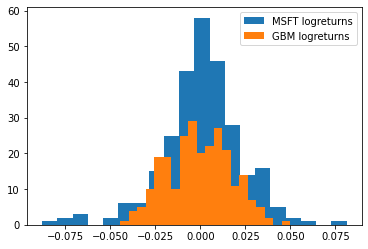

In [48]:
%matplotlib inline
real_data_np = np.array(real_data).reshape(-1, 1)
logrets_real = np.diff(np.log(real_data_np), axis = 0)
plt.hist(logrets_real, label = f'{ticker} logreturns', bins = 20)

logrets_gbm = np.diff(np.log(gbm_traj))
plt.hist(logrets_gbm, label = 'GBM logreturns', bins = 20)
plt.legend()

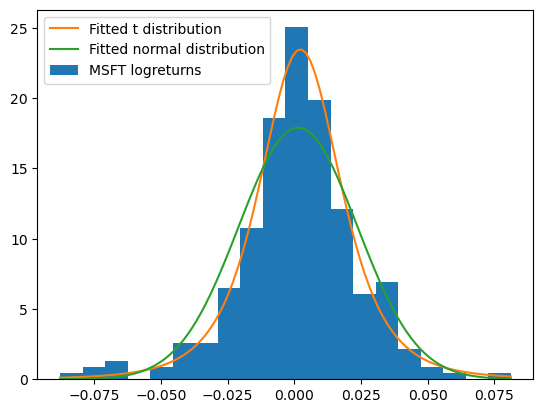

In [50]:
plt.style.use('default')
t_fitted = sc.t.fit(logrets_real)
t_fitted = sc.t(*t_fitted)

norm_fitted = sc.norm.fit(logrets_real)
norm_fitted = sc.norm(*norm_fitted)

cauchy_fitted = sc.cauchy.fit(logrets_real)
cauchy_fitted = sc.cauchy(*cauchy_fitted)

x_axis = np.linspace(logrets_real.min(), logrets_real.max(), 100)
_=plt.hist(logrets_real, label =f'{ticker} logreturns', bins = 20, density = True)
plt.plot(x_axis, t_fitted.pdf(x_axis), label = 'Fitted t distribution')
plt.plot(x_axis, norm_fitted.pdf(x_axis), label = 'Fitted normal distribution')
_= plt.legend()

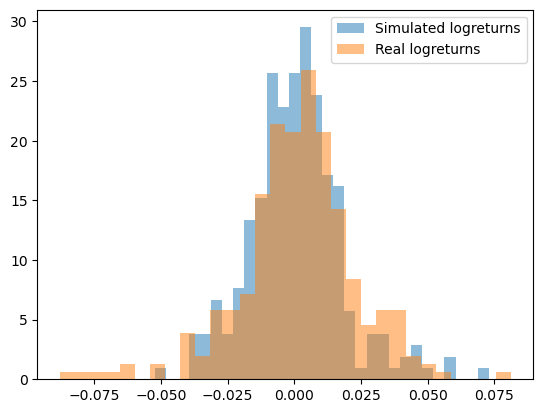

In [51]:
%matplotlib inline
plt.style.use('default')
t_params = sc.t.fit((logrets_real - logrets_real.mean())/logrets_real.std())
t_fit = sc.t(*t_params)

St = gbm(S0 = 100, r = 0.01, sigma = 0.3, T = 1, time_steps=252, n_paths = 1, random_generator = t_fit)
logrets_sim = np.diff(np.log(St), axis = 0)

x_axis = np.linspace(logrets_real.min(), logrets_real.max(), 100)
_ = plt.hist(logrets_sim, label ='Simulated logreturns', bins = 30, density = True, alpha = 0.5)
_ = plt.hist(logrets_real, label ='Real logreturns', bins = 30, density = True, alpha = 0.5)

_ = plt.legend()

In [54]:
def price_MC(stock_trajectory, strike, r, T, option_type):
    
    ST = stock_trajectory[-1, :]
    if option_type == 'CALL':
        payoff = np.maximum(ST - strike, 0).mean()
    else:
        payoff = np.maximum(strike - ST, 0).mean()
    
    return payoff*np.exp(-r*T)

def dynamic_hedging2(stock_trajectory, random_generator, option_to_hedge, option_for_gamma):
    
    gbm_traj = stock_trajectory
    option_type, K = option_to_hedge
    option_type2, K2 = option_for_gamma
    
    t_axis = np.linspace(0, T, len(gbm_traj))
    dt = t_axis[1] - t_axis[0]


    Vt = []
    St = []
    Ct = []
    t=[]

    Strategies = {'DeltaHedge': {"t": [],
                                 "Value": [],
                                 "Stock": [],
                                 "MM": []},
                  'DeltaGammaHedge': {"t": [],
                                      "Value": [],
                                      "Stock": [],
                                      "Option": [],
                                      "MM":[]}
                 }
    for ind, (S, t_) in enumerate(zip(gbm_traj[:-10], t_axis[:-10])):
        K = S*0.9
        K2 = S*1.1
        
        V = vanilla_price(S, K, option_type, r, sig, T-t_)
        C = vanilla_price(S, K2, option_type2, r, sig, T-t_)
        S = S

        if t_ == 0:
            DH = 0.0
            DGH = 0.0
        else:
            DH = Strategies['DeltaHedge']['Stock'][-1]*S + Strategies['DeltaHedge']['MM'][-1]*np.exp(r*dt)
            DGH = Strategies['DeltaGammaHedge']['Stock'][-1]*S + Strategies['DeltaGammaHedge']['Option'][-1]*C + Strategies['DeltaGammaHedge']['MM'][-1]*np.exp(r*dt)

        Strategies['DeltaHedge']['Value'].append(DH)
        Strategies['DeltaGammaHedge']['Value'].append(DGH)

        Vt.append(V)
        St.append(S)
        Ct.append(C)
        t.append(t_)
        
        epsilon = 0.000001
        S_plus = S*(1+epsilon)
        S_minus = S*(1-epsilon)
        dS = S_plus - S_minus
        
        simu_S = gbm(S0 = S, r = 0.01, sigma = 0.3, T = T-t_, time_steps=len(gbm_traj[:-10])-ind, n_paths = 200000, 
                     random_generator = random_generator)
        simu_S_plus = simu_S*(1+epsilon)
        simu_S_minus = simu_S*(1-epsilon)
        
        
        # Greeks
        delta_V = (price_MC(simu_S_plus, K, r, T, option_type) - 
                   price_MC(simu_S_minus, K, r, T, option_type))/(2*dS)
        delta_C = (price_MC(simu_S_plus, K2, r, T, option_type) -
                   price_MC(simu_S_minus, K2, r, T, option_type))/(2*dS)
        delta_S = 1.0

        
        gamma_V = (price_MC(simu_S_plus, K, r, T, option_type) - 
                   2*price_MC(simu_S, K, r, T, option_type) + 
                   price_MC(simu_S_minus, K, r, T, option_type))/(dS**2)
        gamma_C = (price_MC(simu_S_plus, K2, r, T, option_type2) - 
                   2*price_MC(simu_S, K2, r, T, option_type2) + 
                   price_MC(simu_S_minus, K2, r, T, option_type2))/(dS**2)
        gamma_S = 0.0

        print(f"S_{t_:.2f} = {S:.4f}: delta_V = {delta_V:.4f}, delta_C = {delta_C:.4f}, gamma_V = {gamma_V:.4f}, gamma_C = {gamma_C:.4f}")
        # Delta hedging
        A = np.array([[delta_S, 0], [S, 1]])
        B = np.array([[delta_V], [DH]])
        X = np.linalg.solve(A, B)

        Strategies['DeltaHedge']['Stock'].append(X[0][0])
        Strategies['DeltaHedge']['MM'].append(X[1][0])

        #Delta-gamma hedging
        A = np.array([[delta_S, delta_C, 0], [gamma_S, gamma_C, 0], [S, C, 1]])
        B = np.array([[delta_V], [gamma_V], [DGH]])
        X = np.linalg.solve(A, B)

        Strategies['DeltaGammaHedge']['Stock'].append(X[0][0])
        Strategies['DeltaGammaHedge']['Option'].append(X[1][0])
        Strategies['DeltaGammaHedge']['MM'].append(X[2][0])

    t = np.array(t).reshape(-1, 1)
    Vt = np.array(Vt).reshape(-1, 1)
    Strategies['DeltaHedge']['Value'] = np.array(Strategies['DeltaHedge']['Value']).reshape(-1, 1)
    Strategies['DeltaGammaHedge']['Value'] = np.array(Strategies['DeltaGammaHedge']['Value']).reshape(-1, 1)
    
    return t, Vt, Strategies 

In [55]:
t_real, Vt_real, Strategies_real = dynamic_hedging2(real_data, random_generator = t_fit, option_to_hedge = ('CALL', 100), option_for_gamma = ('CALL', 90))

S_0.00 = 138.0500: delta_V = 0.5064, delta_C = 0.4003, gamma_V = -0.0000, gamma_C = 0.0034
S_0.00 = 139.6600: delta_V = 0.5062, delta_C = 0.4000, gamma_V = -0.0000, gamma_C = -0.0000
S_0.01 = 136.2500: delta_V = 0.5044, delta_C = 0.3979, gamma_V = 0.0008, gamma_C = -0.0000
S_0.01 = 134.9500: delta_V = 0.5135, delta_C = 0.4062, gamma_V = -0.0000, gamma_C = -0.0000
S_0.01 = 136.7500: delta_V = 0.5042, delta_C = 0.3971, gamma_V = 0.0022, gamma_C = -0.0000
S_0.02 = 137.1400: delta_V = 0.5039, delta_C = 0.3966, gamma_V = 0.0025, gamma_C = 0.0035
S_0.02 = 137.0800: delta_V = 0.5022, delta_C = 0.3947, gamma_V = 0.0019, gamma_C = -0.0000
S_0.03 = 137.4600: delta_V = 0.5033, delta_C = 0.3952, gamma_V = -0.0000, gamma_C = -0.0000
S_0.03 = 138.4900: delta_V = 0.5020, delta_C = 0.3936, gamma_V = 0.0000, gamma_C = 0.0088
S_0.03 = 140.1200: delta_V = 0.5018, delta_C = 0.3933, gamma_V = 0.0080, gamma_C = 0.0121
S_0.04 = 139.6900: delta_V = 0.5004, delta_C = 0.3926, gamma_V = -0.0000, gamma_C = -0.000

LinAlgError: Singular matrix

In [ ]:
%matplotlib notebook
plt.plot(t_real[1:], Vt_real[1:], label = 'Position')
plt.plot(t_real[1:], Strategies_real['DeltaHedge']['Value'][1:], label = "Hedge")
plt.legend()

run_animation(t_real[1:], Vt_real[1:] - Strategies_real['DeltaHedge']['Value'][1:], "Delta hedged position")